## Import libraries

In [1]:
import os

import keras
import tensorflow as tf
import sklearn as skl

import h5py
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from datetime import datetime

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

2025-02-22 16:35:13.867034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 16:35:14.005164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740238514.059568    1059 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740238514.075361    1059 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 16:35:14.250981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

 ## Data fetching and cleaning

In [2]:
train_image_file = h5py.File('train-image.hdf5', 'r')
train_metadata_ = pd.read_csv("train-metadata.csv", low_memory=False)

test_image_file = h5py.File('test-image.hdf5', 'r')
test_metadata_ = pd.read_csv("test-metadata.csv", low_memory=False)

benign_labels = train_metadata_.loc[train_metadata_['target'] == 0]["isic_id"]
malignant_labels = train_metadata_.loc[train_metadata_['target'] == 1]["isic_id"]

print("Number of train images: ", len(list(train_image_file.keys())))
print("Train metadata shape: ", train_metadata_.shape)

print()

print("Number of test images: ", len(list(test_image_file.keys())))
print("Test metadata shape: ", test_metadata_.shape)

print()

print("Number of benign train images: ", len(benign_labels))
print("Number of malignant train images: ", len(malignant_labels))


Number of train images:  401059
Train metadata shape:  (401059, 55)

Number of test images:  3
Test metadata shape:  (3, 44)

Number of benign train images:  400666
Number of malignant train images:  393


 ### Metadataset segmentation



 #### Columns to drop :

 - patient_id: For privacy issues

 - image_type: It's a constant

 - attribution: Provides no information

 - copyright_license: Provides no information

 - lesion_id: Provides no information



 #### Column set aside for image identification and check alignement with the metadata:

 - isic_id: Link between images and their metadata



 #### Column set aside for labelling:

 - target: Tells if an image is benign or malignant



 #### Columns set aside for further pronostics (bonus project):

 - iddx_[(full)1-5]: Verbal diagnosis on different levels

 - mel_mitotic_index, mel_thick_mm: Physical malignant lesion characteristics

 - tbp_lv_dnn_lesion_confidence: Lesion confidence score

In [3]:
train_metadata: pd.DataFrame = train_metadata_.copy()

columns_to_drop = ['patient_id', 'image_type', 'attribution', 'copyright_license', 'lesion_id']
train_metadata = train_metadata.drop(columns_to_drop, axis=1)

pronostics = ['iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
              'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']
train_pronostics = pd.concat([train_metadata.pop(col) for col in pronostics], axis=1)

train_labels = train_metadata.pop('target')
print(train_labels.shape)

train_isic_id = train_metadata.pop('isic_id')

n_columns = train_metadata.shape[1]


test_metadata: pd.DataFrame = test_metadata_.copy()

columns_to_drop = ['patient_id', 'image_type', 'attribution', 'copyright_license']
test_metadata = test_metadata.drop(columns_to_drop, axis=1)

test_isic_id = test_metadata.pop('isic_id')


(401059,)


 ### Data conversion to only numeric values



 #### Columns that need to be converted:

 - sex

 - anatom_site_general

 - anatom_site_general

 - tbp_tile_type

 - tbp_lv_location

 - tbp_lv_location_simple

In [4]:
locations = ['Right Leg - Upper', 'Head & Neck', 'Torso Back Top Third', 'Torso Front Top Half',
             'Right Arm - Upper', 'Left Leg - Upper', 'Torso Front Bottom Half', 'Left Arm - Upper',
             'Right Leg', 'Torso Back Middle Third', 'Right Arm - Lower', 'Right Leg - Lower',
             'Left Leg - Lower', 'Left Arm - Lower', 'Left Leg', 'Torso Back Bottom Third', 'Left Arm',
             'Right Arm', 'Torso Front', 'Torso Back']
locations.sort()
locations = set(locations)
n_locations = list(range(len(locations)))

train_metadata['sex'] = train_metadata['sex'].replace(('male', 'female'),(0, 1))
train_metadata['anatom_site_general'] = (train_metadata['anatom_site_general']
                                         .replace(('lower extremity', 'head/neck', 'posterior torso', 'anterior torso', 'upper extremity'),
                                                  (0, 1, 2, 3, 4)))
train_metadata['anatom_site_general'] = (train_metadata['anatom_site_general']
                                         .replace(('lower extremity', 'head/neck', 'posterior torso', 'anterior torso', 'upper extremity'),
                                                  (0, 1, 2, 3, 4)))
train_metadata['tbp_tile_type'] = (train_metadata['tbp_tile_type'].replace(('3D: white', '3D: XP'),(0, 1)))
train_metadata['tbp_lv_location'] = (train_metadata['tbp_lv_location'].replace(locations,n_locations))
# I will pass 'Unknown' values as nan so they can be filled by imputation
train_metadata['tbp_lv_location'] = (train_metadata['tbp_lv_location'].replace('Unknown', np.nan))
# I will keep the same replacement as above even if their not all used for continuity
train_metadata['tbp_lv_location_simple'] = (train_metadata['tbp_lv_location_simple'].replace(locations,n_locations))
train_metadata['tbp_lv_location_simple'] = (train_metadata['tbp_lv_location_simple'].replace('Unknown', np.nan))

test_metadata['sex'] = test_metadata['sex'].replace(('male', 'female'),(0, 1))
test_metadata['anatom_site_general'] = (test_metadata['anatom_site_general']
                                         .replace(('lower extremity', 'head/neck', 'posterior torso', 'anterior torso', 'upper extremity'),
                                                  (0, 1, 2, 3, 4)))
test_metadata['anatom_site_general'] = (test_metadata['anatom_site_general']
                                         .replace(('lower extremity', 'head/neck', 'posterior torso', 'anterior torso', 'upper extremity'),
                                                  (0, 1, 2, 3, 4)))
test_metadata['tbp_tile_type'] = (test_metadata['tbp_tile_type'].replace(('3D: white', '3D: XP'),(0, 1)))
test_metadata['tbp_lv_location'] = (test_metadata['tbp_lv_location'].replace(locations,n_locations))
# I will pass 'Unknown' values as nan so they can be filled by imputation
test_metadata['tbp_lv_location'] = (test_metadata['tbp_lv_location'].replace('Unknown', np.nan))
# I will keep the same replacement as above even if their not all used for continuity
test_metadata['tbp_lv_location_simple'] = (test_metadata['tbp_lv_location_simple'].replace(locations,n_locations))
test_metadata['tbp_lv_location_simple'] = (test_metadata['tbp_lv_location_simple'].replace('Unknown', np.nan))


 ### Data normalization



 #### Columns that can be normalized:

 - tbp_lv_H: 25-75

 - tbp_lv_area_perim_ratio: 0-10

 - tbp_lv_deltaLBnorm: 5.5-25

 - tbp_lv_nevi_confidence: 0-100

 - tbp_lv_norm_border: 0-10

 - tbp_lv_norm_color: 0-10

 - tbp_lv_radial_color_std_max: 0-10

 - tbp_lv_symm_2axis: 0-10

 - tbp_lv_symm_2axis_angle: 0-180

 - (tbp_lv_dnn_lesion_confidence: 0-100) TODO if we make a written diagnosis

In [5]:
train_metadata['tbp_lv_H'] = (train_metadata['tbp_lv_H'] - 25) / (75 - 25)
train_metadata['tbp_lv_area_perim_ratio'] = train_metadata['tbp_lv_area_perim_ratio'] / 10
train_metadata['tbp_lv_deltaLBnorm'] = (train_metadata['tbp_lv_H'] - 5.5) / (25 - 5.5)
train_metadata['tbp_lv_nevi_confidence'] = train_metadata['tbp_lv_nevi_confidence'] / 100
train_metadata['tbp_lv_norm_border'] = train_metadata['tbp_lv_norm_border'] / 10
train_metadata['tbp_lv_norm_color'] = train_metadata['tbp_lv_norm_color'] / 10
train_metadata['tbp_lv_radial_color_std_max'] = train_metadata['tbp_lv_radial_color_std_max'] / 10
train_metadata['tbp_lv_symm_2axis'] = train_metadata['tbp_lv_symm_2axis'] / 10
train_metadata['tbp_lv_symm_2axis_angle'] = train_metadata['tbp_lv_symm_2axis_angle'] / 180
# Might need in the future to reduce values sizes for some tbp_lv_* columns for training efficiency

test_metadata['tbp_lv_H'] = (test_metadata['tbp_lv_H'] - 25) / (75 - 25)
test_metadata['tbp_lv_area_perim_ratio'] = test_metadata['tbp_lv_area_perim_ratio'] / 10
test_metadata['tbp_lv_deltaLBnorm'] = (test_metadata['tbp_lv_H'] - 5.5) / (25 - 5.5)
test_metadata['tbp_lv_nevi_confidence'] = test_metadata['tbp_lv_nevi_confidence'] / 100
test_metadata['tbp_lv_norm_border'] = test_metadata['tbp_lv_norm_border'] / 10
test_metadata['tbp_lv_norm_color'] = test_metadata['tbp_lv_norm_color'] / 10
test_metadata['tbp_lv_radial_color_std_max'] = test_metadata['tbp_lv_radial_color_std_max'] / 10
test_metadata['tbp_lv_symm_2axis'] = test_metadata['tbp_lv_symm_2axis'] / 10
test_metadata['tbp_lv_symm_2axis_angle'] = test_metadata['tbp_lv_symm_2axis_angle'] / 180


 ### Replace NaN values



 #### Multiple strategies to experiment to replace NaN values:

 - With a constant like 0

 - With a constant marking imputed values like -1 (sklearn.impute.MissingIndicator)

 - With the mean of the column (sklearn.impute.SimpleImputer)

 - With multivariate feature imputation (sklearn.impute.IterativeImputer)

 - With KNN imputation (sklearn.impute.KNNImputer)

In [6]:
train_imputer = skl.impute.IterativeImputer(random_state=0)
train_imputer.fit(train_metadata)
train_metadata = train_imputer.transform(train_metadata)

In [7]:
test_imputer = skl.impute.IterativeImputer(random_state=0)
test_imputer.fit(test_metadata)
test_metadata = test_imputer.transform(test_metadata)

 ## Model definition

 #### Strategies on how to use the CNN and NN models:

 - Merge them by making them share the same output layer

 - Use the CNN output as the NN input

 ### Data augmentation



 Since the images that we are going to use contain sensitive information, we cannot alter it without asking ourselves how it would affect it.



 #### Prohibited alterations:

 - Hue change: Impacts the colour of the lesion and the colour of the patient skin

 - Brightness | Contrast: Impacts the colour of the lesion and the colour of the patient skin

 - Zoom | Translation: Might get the lesion out of sight



 #### Authorized alterations:

 - Flip

 - Rotation



 #### Experimental alterations:

 - Sharpness: The model could be more robust to images being blured or well taken and make the lesion more prominent in the image by outlining it

In [8]:
cnn = keras.models.Sequential([
    keras.layers.Input((128, 128, 3)),

    keras.layers.RandomFlip(name='CNN_input'),
    keras.layers.RandomRotation(factor=0.3),
    keras.layers.RandomSharpness(factor=1.),

    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(strides=1, padding='same'),

    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(strides=1, padding='same'),

    keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(512, (5, 5), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(strides=1, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(20, 'relu'),
    keras.layers.Dense(10, 'relu'),
    keras.layers.Dense(1, 'sigmoid', name='CNN_output')
])

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=['binary_validation'])

cnn.summary()


I0000 00:00:1740238634.807825    1059 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CNN_input (RandomFlip)          │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_sharpness                │ (None, 128, 128, 3)    │             0 │
│ (RandomSharpness)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 512)  │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8388608)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │   167,772,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_output (Dense)              │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,420,529 (653.92 MB)

 Trainable params: 171,420,529 (653.92 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
nn = keras.models.Sequential([
    keras.layers.Input((n_columns,)),

    keras.layers.Dense(50, 'relu', name='NN_input'),
    keras.layers.Dense(10, 'relu'),
    keras.layers.Dense(1, 'sigmoid', name='NN_output'),
])

nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
           loss=keras.losses.BinaryCrossentropy(),
           metrics=['binary_validation'])

nn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NN_input (Dense)                │ (None, 50)             │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ NN_output (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

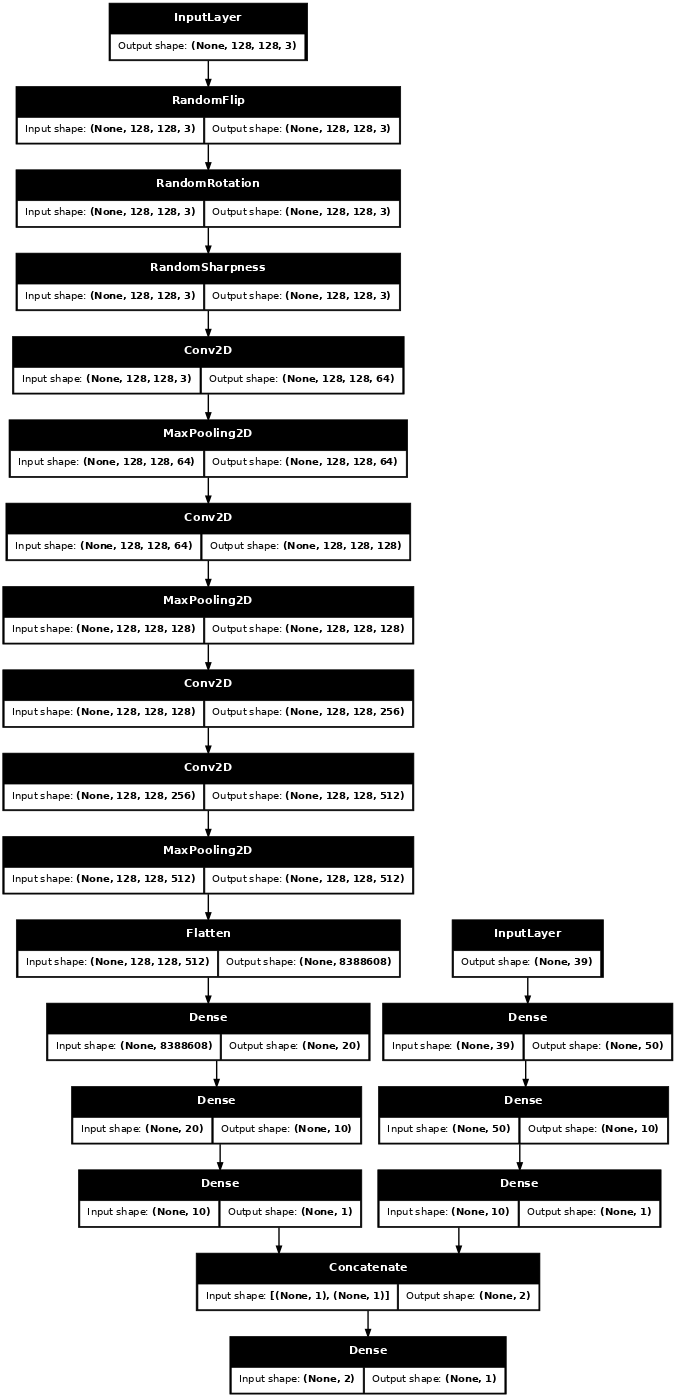

In [10]:
try:
    del model
    import gc
    keras.backend.clear_session()
    gc.collect()
except:
    pass

merge_layer = keras.layers.Concatenate()([cnn.get_layer('CNN_output').output, nn.get_layer('NN_output').output])
final_layer = keras.layers.Dense(1, 'sigmoid')(merge_layer)

model = keras.Model([cnn.get_layer('CNN_input').input, nn.get_layer('NN_input').input], final_layer,)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'],)

keras.utils.plot_model(model, show_shapes=True, dpi=50)
# model.summary()


 ## Model training

In [13]:
BATCH_SIZE = 32
EPOCH = 100
STEPS_PER_EPOCH = 50

DATASET_SIZE = train_metadata.shape[0]
TRAIN_DATASET_SIZE = int(DATASET_SIZE * 0.8)
VAL_DATASET_SIZE = DATASET_SIZE - TRAIN_DATASET_SIZE

TB_PATH = "./tmp/logs/"

LOAD_WEIGHTS = True
FORMER_INSTANCE = "e_100_spt_50_bs_32_2025-02-15_02-02-37"

print(DATASET_SIZE, TRAIN_DATASET_SIZE, VAL_DATASET_SIZE)

401059 320847 80212


In [14]:
class MergeGenerator:
    def __init__(self, file, metadata, labels, ids):
        self.file: h5py.File = file
        self.metadata: pd.DataFrame = metadata
        self.labels: pd.DataFrame = labels
        self.ids: pd.DataFrame = ids

    def __call__(self):
        for image, metadata, label, id in zip(self.file.keys(), self.metadata, self.labels, self.ids):
            if image != id:
                raise Exception("The images and their IDs are not alined. Please check the order.")
            
            yield (np.array(Image.open(BytesIO(self.file[image][()])).resize((128, 128))) / 255, metadata), label
            # Need to review how images are resized so they are not distorted

dataset: tf.data.Dataset = tf.data.Dataset.from_generator(MergeGenerator(train_image_file, train_metadata, train_labels, train_isic_id),
                                               output_signature=((tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name="Images"), 
                                                                 tf.TensorSpec(shape=(n_columns, ), dtype=tf.float32, name="Metadata")),
                                                                 tf.TensorSpec(shape=(), dtype=tf.float32, name="Targets"))).batch(BATCH_SIZE)

# dataset = dataset.shuffle(DATASET_SIZE)


train_dataset = dataset.take(TRAIN_DATASET_SIZE)
validation_dataset = dataset.skip(TRAIN_DATASET_SIZE)

# dummy = next(iter(train_dataset))
# print((dummy[0].shape, dummy[1].shape, dummy[2].shape))
# print(dummy)


In [15]:
if LOAD_WEIGHTS:
    model.load_weights("./weights/" + FORMER_INSTANCE + ".weights.h5")

/home/chipchop/anaconda3/envs/3d-tbp/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
instance_name = "e_" + str(EPOCH) + "_spt_" + str(STEPS_PER_EPOCH) + "_bs_" + str(BATCH_SIZE) + "_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TB_PATH + "fit/" + instance_name, update_freq="epoch")

history = model.fit(train_dataset,
                    epochs=EPOCH,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks=[tensorboard_callback])

Epoch 1/100


50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - binary_accuracy: 0.8216 - loss: 0.7140
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - binary_accuracy: 0.9902 - loss: 0.6632
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - binary_accuracy: 0.9989 - loss: 0.6395
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - binary_accuracy: 0.9967 - loss: 0.6174
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - binary_accuracy: 0.9990 - loss: 0.5953
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - binary_accuracy: 0.9969 - loss: 0.5750
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - binary_accuracy: 0.9981 - loss: 0.5547
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - binary_accuracy: 1.0000 - loss: 0.5348
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - binary_accuracy: 0.9986 - loss: 0.5167
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - binary_accuracy: 0.9978 - loss: 0.4993
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - bina

### Save model weight for future uses if needed

Must be done in moderation since a single file will have a size of almost 2GB.

In [44]:
os.makedirs("./weights", exist_ok=True)

weights_file = "./weights/" + instance_name + ".weights.h5"
model.save_weights(weights_file)

print("Weights saved in file " + weights_file)

Weights saved in file ./weights/e_100_spt_50_bs_32_2025-02-15_02-02-37.weights.h5


./tmp/logs/fit/e_100_spt_50_bs_32_2025-02-15_02-02-37/train/events.out.tfevents.1739581357.ChipChop.268432.1.v2


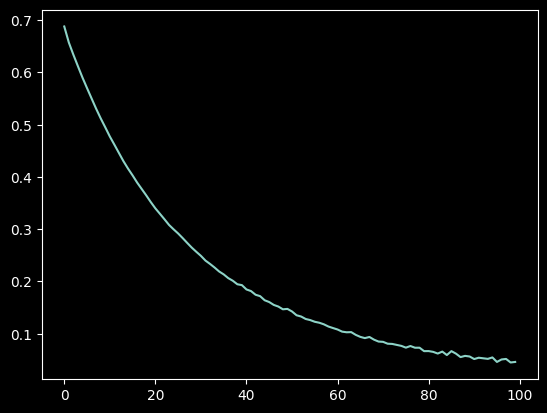

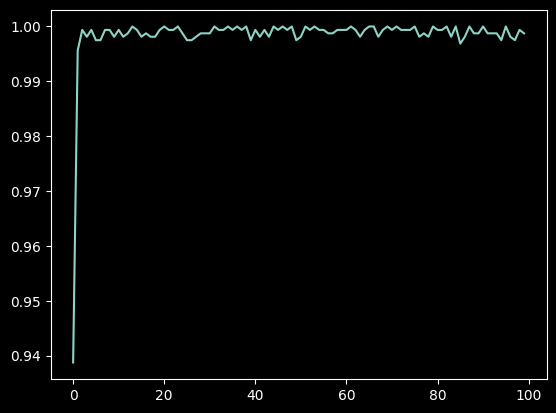

In [80]:
event_directory = TB_PATH + "fit/" + instance_name + "/train/" if not LOAD_WEIGHTS else TB_PATH + "fit/" + FORMER_INSTANCE + "/train/"

loss = []
binary_accuracy = []

print(event_directory + os.listdir(event_directory)[0])

for e in tf.compat.v1.train.summary_iterator(event_directory + os.listdir(event_directory)[0]):
    for v in e.summary.value:
        if v.tag == "epoch_loss":
            loss.append(tf.make_ndarray(tf.make_tensor_proto(v.tensor)))
        elif v.tag == "epoch_binary_accuracy":
            binary_accuracy.append(tf.make_ndarray(tf.make_tensor_proto(v.tensor)))


plt.plot(loss)
plt.show()

plt.plot(binary_accuracy)
plt.show()

 ## Model testing

In [16]:
class MergeGenerator:
    def __init__(self, file, metadata, ids):
        self.file: h5py.File = file
        self.metadata: pd.DataFrame = metadata
        self.ids: pd.DataFrame = ids

    def __call__(self):
        for image, metadata, id in zip(self.file.keys(), self.metadata, self.ids):
            if image != id:
                raise Exception("The images and their IDs are not alined. Please check the order.")
            
            yield (np.array(Image.open(BytesIO(self.file[image][()])).resize((128, 128))) / 255, metadata),
            # Need to review how images are resized so they are not distorted

test_dataset: tf.data.Dataset = tf.data.Dataset.from_generator(MergeGenerator(test_image_file, test_metadata, test_isic_id),
                                               output_signature=((tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name="Images"), 
                                                                 tf.TensorSpec(shape=(n_columns, ), dtype=tf.float32, name="Metadata")),)).batch(BATCH_SIZE)

print(test_dataset.element_spec)


((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 39), dtype=tf.float32, name=None)),)


In [17]:
test_tb_callback = tf.keras.callbacks.TensorBoard(log_dir=TB_PATH + "test/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
                                                      update_freq="epoch")
predictions = model.predict(test_dataset, callbacks=[test_tb_callback])

print(predictions)


I0000 00:00:1740238665.966623    3906 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.04068851]
 [0.04068851]
 [0.04068851]]


2025-02-22 16:37:46.782182: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/chipchop/anaconda3/envs/3d-tbp/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


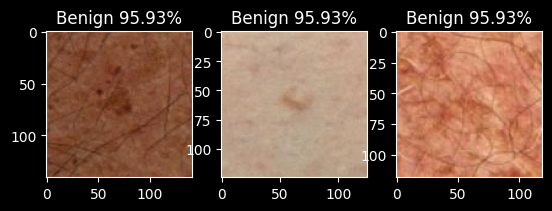

In [18]:
keys = list(test_image_file.keys())

fig, ax = plt.subplots(1,3)

for i in range(3):
    prediction = "Benign " + str(np.round((1 - predictions[i]) * 100, 2)[0]) + "%" if predictions[i] < 0.5 else "Malignant " + str(np.round((1 - predictions[i]) * 100, 2)[0]) + "%"
    ax[i].title.set_text(prediction)
    ax[i].imshow(np.asarray(Image.open(BytesIO(test_image_file[keys[i]][()]))))

plt.show()
